In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
os.sys.path.append('../..')
from qincm.qincm import QINCM
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import json
import copy

In [3]:
inputdir = Path('../../data')
example_dir = Path('data')
outputdir = Path('results')

In [4]:
route_depth_costs_file = inputdir / 'route_depth_costs.json'
knelpunt_discharge_depth_file = inputdir / 'knelpunt_discharge_waterdepth.json'
reference='BR_Duitsland'

In [5]:
# Reference model for all simulations below
M = QINCM(
    route_depth_costs_file,
    knelpunt_discharge_depth_file,
    reference=reference
)

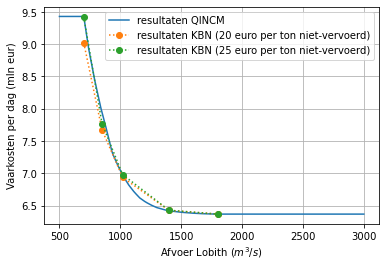

In [77]:
Q_range = np.linspace(500, 3000, 251)
costs = M.costs_per_discharge(Q_range, ).sum(axis=1)

(costs /1e6).plot(label='resultaten QINCM')

ref_data = pd.read_csv(example_dir  /'Afvoer-Totale Vaarkosten per dag_inclNV_kostenperton20.csv', index_col=0).iloc[:5, 0] * 1e6
ref_data.index = [float(i[1:]) for i in ref_data.index]
(ref_data / 1e6).plot(ax=plt.gca(), marker='o', label='resultaten KBN (20 euro per ton niet-vervoerd)', ls=':')

ref_data = pd.read_csv(example_dir  /'Afvoer-Totale Vaarkosten per dag_inclNV_kostenperton25.csv', index_col=0).iloc[:5, 0] * 1e6
ref_data.index = [float(i[1:]) for i in ref_data.index]
(ref_data / 1e6).plot(ax=plt.gca(), marker='o', label='resultaten KBN (25 euro per ton niet-vervoerd)', ls=':')


plt.legend()
plt.grid()
plt.xlabel('Afvoer Lobith ($m^3/s$)')
plt.ylabel('Vaarkosten per dag (mln eur)')
plt.savefig(outputdir / 'Vaarkosten_per_dag.png', bbox_inches='tight', dpi=150)

In [8]:
ts = pd.read_excel(example_dir / 'Rijn_1911_2019.xlsx', sheet_name='2015_2019', skiprows=5, header=None).iloc[:,1:]
ts.columns=['year', 'month', 'day', 'Metingen']
ts.index = pd.to_datetime(ts[['year', 'month', 'day']])
ts.drop(['year', 'month', 'day'], axis=1, inplace=True)
ts = ts['Metingen']

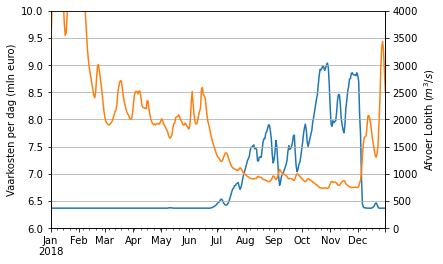

In [21]:
(M.costs_per_discharge(ts['2018']).sum(axis=1) / 1e6).plot()
plt.ylabel('Vaarkosten per dag (mln euro)')
plt.ylim(6, 10)
ax2 = plt.twinx()
ts['2018'].plot(ax=ax2, c='C1')
plt.ylabel('Afvoer Lobith ($m^3/s$)')
plt.grid()
plt.ylim(0, 4000)
plt.savefig(outputdir / 'Vaarkosten_per_dag_tijdserie.png', bbox_inches='tight', dpi=150)

In [10]:
# Read years of average and return periods
Q_year = pd.read_excel(example_dir / 'Average.xlsx', index_col=0)['Ref']

CDF = pd.read_excel(example_dir / 'CDF.xlsx', index_col=0, header=[0, 1])

# Mirror levels they were meant for overschrijdingsduur (not onderschrijdingsduur)
CDF = CDF.rename(columns={ 
    1: 'T100', # 100 of 100
    2: 'T2', # 50 of 100 years
#     10: 'T10', # 10 of 100 years 
#     50: 'T2', # 2 of 100 years
    100: 'T1' # 1 of 100
}).drop([10, 50], axis=1, level=-1)

In [11]:
def compute_costs(M):
    scenario_results = {}
    dt = (Q_year.index[0] - Q_year.index[1]) * 365
    scenario_results['Gemiddeld'] = M.costs_for_scenario(Q_year.values, dt, delta=True)

    for T in ['T1', 'T2', 'T100']:
        dt = (CDF.index[0] - CDF.index[1]) * 365
        scenario_results[f'{T}'] = M.costs_for_scenario(CDF[('Ref', T)].values, dt, delta=True)

    scenario_results = pd.concat(scenario_results, axis=1)
    return scenario_results

scenario_results = compute_costs(M)

In [12]:
def inverselegend(outside=False, **kwargs):
    if outside:
        return plt.gca().legend(*map(reversed, plt.gca().get_legend_handles_labels()), loc='center left',
                         bbox_to_anchor=(1, 0.5), **kwargs)
    else:
        return plt.gca().legend(*map(reversed, plt.gca().get_legend_handles_labels()), **kwargs)

In [69]:
KBN_ref = pd.read_excel(example_dir / 'Vaarkosten_inclNV_kostenperton25.xlsx', index_col=0)['Ref']
KBN_ref -= KBN_ref['T1']

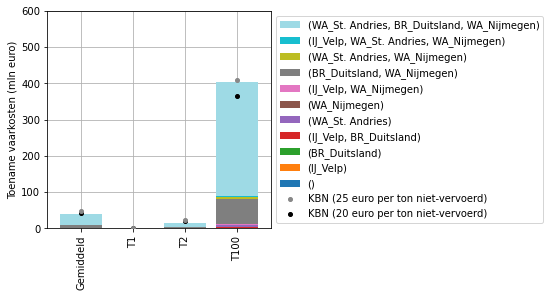

In [74]:
def plot_results(scenario_results, ax):
    plt.sca(ax)
    (scenario_results.T / 1e6).plot.bar(width=0.8, zorder=3, stacked=True, cmap='tab20', ax=ax)
    plt.grid()
    plt.ylabel('Toename vaarkosten (mln euro)')
    inverselegend(outside=True)
    plt.ylim(0, 600)
f, ax = plt.subplots(figsize=(4,4))

KBN_ref = pd.read_excel(example_dir / 'Vaarkosten_inclNV_kostenperton20.xlsx', index_col=0)['Ref']
KBN_ref -= KBN_ref['T1']
KBN_ref.loc[['Gemiddeld', 'T1', 'T2', 'T100']].plot(ax=ax, zorder=4, marker='o', c='k', ls='none', markersize=4, label='KBN (20 euro per ton niet-vervoerd)')

KBN_ref = pd.read_excel(example_dir / 'Vaarkosten_inclNV_kostenperton25.xlsx', index_col=0)['Ref']
KBN_ref -= KBN_ref['T1']
KBN_ref.loc[['Gemiddeld', 'T1', 'T2', 'T100']].plot(ax=ax, zorder=4, marker='o', c='#888888', ls='none', markersize=4, label='KBN (25 euro per ton niet-vervoerd)')

plot_results(scenario_results, ax)
plt.savefig(outputdir / 'Kosten_per_jaar.png', bbox_inches='tight', dpi=150)

In [14]:
def plot_QVD(Q_VD, ax):
    plt.sca(ax)
    
    Q_ref = [float(q) for q in Q_VD_ref[reference].keys()]
    for k in knelpunten:
        ax.plot(Q_ref, Q_VD[k].values())
    plt.ylim(1, 5)
    plt.xlabel('Discharge at reference ($m^3/s$)')
    plt.ylabel('Waterdepth (m)')
    plt.grid()

In [15]:
# Function correct 
def effect_correct_depth(plot=True, **knelpunten):
    Q_VD = copy.deepcopy(Q_VD_ref)
    for k, dh in knelpunten.items():
        for q in Q_VD[k].keys():
            Q_VD[k][q] += dh
        
    M._read_knelpunt_discharge_depth(Q_VD, reference=reference)
        
    scenario_results = compute_costs(M)
    
    if plot:
        # Plot results
        f, ax = plt.subplots(figsize=(8,4), ncols=2)
        plt.subplots_adjust(wspace=0.3)
        plot_QVD(Q_VD, ax=ax[0])
        plot_results(scenario_results, ax=ax[1])
    else:
        return scenario_results

In [16]:
with open(knelpunt_discharge_depth_file) as fin:
    Q_VD_ref = json.load(fin)

knelpunten = Q_VD_ref.keys()

# Create widgets and GUI
w = {}
for k in knelpunten:
    w[k] = widgets.FloatSlider(min=-0.5, max=0.5, description=k)
ui = widgets.HBox(list(w.values()))

out = widgets.interactive_output(effect_correct_depth, w)
display(ui, out)

Output()

Run time for 4 knelpunten, and 11 variations per knelpunt (so total: 44)
Wall time: 4.68 s


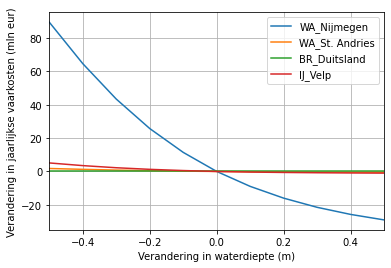

In [24]:
%%time

D_adjust = np.linspace(-0.5, 0.5, 11) 

f, ax = plt.subplots()
for k in knelpunten:
    correction = {k: 0 for k in knelpunten}
    
    C = {}
    for d in D_adjust:
        correction[k] = d
        c = effect_correct_depth(plot=False, **correction)
        C[d] = c.sum()['Gemiddeld']
    C = pd.Series(C)
    C = C - C[0]
    C = C / 1e6
    C.plot(label=k)
    
plt.grid()
plt.legend()
plt.autoscale(axis='x', tight=True)
plt.ylabel('Verandering in jaarlijkse vaarkosten (mln eur)' )
plt.xlabel('Verandering in waterdiepte (m)')

print(f'Run time for {len(knelpunten)} knelpunten, and {len(D_adjust)} variations per knelpunt (so total: {len(knelpunten) * len(D_adjust)})')

plt.savefig(outputdir / 'Effect_verandering_knelpunten.png', bbox_inches='tight', dpi=150)

In [18]:
# SImilar but with QQ

In [25]:
# Q_local = Q_year
# dt = (Q_year.index[0] - Q_year.index[1]) * 365
# M.costs_for_scenario(Q_local, dt, delta=True).sum()

In [26]:
# dt = (Q_year.index[0] - Q_year.index[1]) * 365
# M.costs_for_scenario(Q_local, dt, delta=True).sum()

39896457.033000864

In [27]:
def correct_Q(Q_year, afvoer_aanpassing):
    Q_local = np.transpose([M.knelpunt_discharge_distribution[k](Q_year) for k in knelpunten])
    
    for ii, k in enumerate(knelpunten):
        Q_local[:,ii] += afvoer_aanpassing[k]
    return Q_local

In [28]:
def compute_costs_Q(M, afvoer_aanpassing):
    scenario_results = {}
    dt = (Q_year.index[0] - Q_year.index[1]) * 365
    Q_local = correct_Q(Q_year.values, afvoer_aanpassing)
    scenario_results['Gemiddeld'] = M.costs_for_scenario(Q_local, dt, delta=True)

    for T in ['T1', 'T2', 'T100']:
        dt = (CDF.index[0] - CDF.index[1]) * 365
        Q_local = correct_Q(CDF[('Ref', T)].values, afvoer_aanpassing)
        scenario_results[f'{T}'] = M.costs_for_scenario(Q_local, dt, delta=True)

    scenario_results = pd.concat(scenario_results, axis=1)
    return scenario_results

scenario_results = compute_costs(M)

In [29]:
def plot_Q(afvoer_aanpassing, ax):
    plt.sca(ax)
    
    Q_ref = np.linspace(500, 2000, 100)
    for ii, k in enumerate(knelpunten):
        Q_local = M.knelpunt_discharge_distribution[k](Q_ref)
        Q_local += afvoer_aanpassing[k]
        ax.plot(Q_ref, Q_local, label=k)
    plt.ylim(0, 2000)
    plt.xlabel('Discharge at reference ($m^3/s$)')
    plt.ylabel('Discharge local ($m^3/s$)')
    plt.grid()

# f, ax = plt.subplots()
# plot_Q(Q_local, ax)

In [30]:
# Function correct 
def effect_correct_depth_Q(plot=True, **afvoer_aanpassing):

    scenario_results = compute_costs_Q(M, afvoer_aanpassing)
    
    if plot:
        # Plot results
        f, ax = plt.subplots(figsize=(8,4), ncols=2)
        plt.subplots_adjust(wspace=0.3)
        plot_Q(afvoer_aanpassing, ax=ax[0])
        plot_results(scenario_results, ax=ax[1])
    else:
        return scenario_results

In [31]:
with open(knelpunt_discharge_depth_file) as fin:
    Q_VD_ref = json.load(fin)

knelpunten = Q_VD_ref.keys()

# Create widgets and GUI
w = {}
for k in knelpunten:
    w[k] = widgets.FloatSlider(min=-100, max=100, description=k, step=10)
ui = widgets.HBox(list(w.values()))

out = widgets.interactive_output(effect_correct_depth_Q, w)
display(ui, out)

Output()

Run time for 4 knelpunten, and 21 variations per knelpunt (so total: 84)
Wall time: 8.14 s


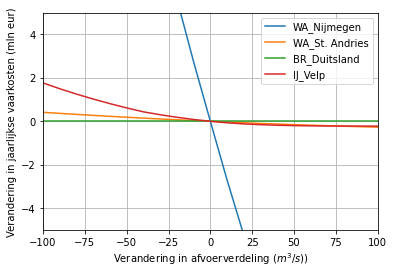

In [32]:
%%time

D_adjust = np.linspace(-100, 100, 21) 

f, ax = plt.subplots()
for k in knelpunten:
    correction = {k: 0 for k in knelpunten}
    
    C = {}
    for d in D_adjust:
        correction[k] = d
        c = compute_costs_Q(M, correction)
        C[d] = c.sum()['Gemiddeld']
    C = pd.Series(C)
    C = C - C[0]
    C = C / 1e6
    C.plot(label=k)
    
plt.grid()
plt.legend()
plt.autoscale(axis='x', tight=True)
plt.ylabel('Verandering in jaarlijkse vaarkosten (mln eur)' )
plt.xlabel('Verandering in afvoerverdeling ($m^3/s$))')
plt.ylim(-5, 5)

print(f'Run time for {len(knelpunten)} knelpunten, and {len(D_adjust)} variations per knelpunt (so total: {len(knelpunten) * len(D_adjust)})')
plt.savefig(outputdir / 'Effect_verandering_knelpunten_afvoer.png', bbox_inches='tight', dpi=150)